In [1]:
import math
import cmath 
import numpy as np
import matplotlib.pyplot as plt
from skrf import Network, Frequency
from skrf import network

from IPython.display import Image  
%matplotlib inline
params = {'legend.fontsize': 24,
          'figure.figsize': (10, 10),
         'axes.labelsize': 24,
         'axes.titlesize': 24,
         'xtick.labelsize':24,
         'ytick.labelsize':24}
plt.rcParams.update(params)

In [24]:
# El siguiente codigo permite cargar los archivos exportados 
# de LTspice

# Numero de punto de medición
numMed = 100

# Genero la variable compatible con SKRF (numpy)
y = np.empty(shape=(numMed,2,2), dtype=complex)
f = np.empty(shape=(numMed),     dtype=complex)
z0=50

# Cargo el archivo de mediciones de la fuente en la entrada y tensión de salida cero
file_y11_y21 = open('ejercicios1/modelos/SPICE/2n3819CASC_y11_y21.txt', 'r')

i =0 
ifFirst = True
for linea in file_y11_y21:   
    if ifFirst: 
        ifFirst = False
    else:    
        l = linea.split('\t')
        f[i]      = float(l[0])
        y[i,0,0]  = float(l[1].split(',')[0]) + 1j*float(l[1].split(',')[1]) 
        y[i,1,0]  = float(l[2].split(',')[0]) + 1j*float(l[2].split(',')[1]) 
        i += 1
file_y11_y21.close()

# Cargo el archivo de mediciones de la fuente en la salida y tensión de entrada cero
file_y12_y22 = open('ejercicios1/modelos/SPICE/2n3819CASC_y12_y22.txt', 'r')

i =0 
ifFirst = True
for linea in file_y12_y22:   
    if ifFirst: 
        ifFirst = False
    else:    
        l = linea.split('\t')
        f[i]      = float(l[0])
        y[i,0,1]  = float(l[1].split(',')[0]) + 1j*float(l[1].split(',')[1]) 
        y[i,1,1]  = float(l[2].split(',')[0]) + 1j*float(l[2].split(',')[1])
        i += 1
file_y12_y22.close()


# Cargo la frecuencia 
freq = Frequency.from_f(f, unit='mhz')
# Las variables deben estar en parametros S
a = network.y2s(y,z0=z0)
# Variable SKRF
modelo = Network(frequency=freq, s= a, z0=z0)
    




In [68]:
fo = 100e6
wo = 2*np.pi*fo

print('Parametros S 100MHz (4V4mA):')

print(modelo[50].s[0])
print(' ')

print('Parametros Y 100MHz (4V4mA):')
print('Y11 = {:1.2e}'.format(modelo[10].y[0][0,0]) )
print('Y12 = {:1.2e}'.format(modelo[10].y[0][0,1]) )
print('Y21 = {:1.2e}'.format(modelo[10].y[0][1,0]) )
print('Y22 = {:1.2e}'.format(modelo[10].y[0][1,1]) )


print(modelo.frequency[9])


Parametros S 100MHz (4V4mA):
[[6.13449065e-01-6.32118462e-01j 2.22095565e-04+4.01155465e-07j]
 [1.10288899e-01+2.02417012e-01j 9.60952598e-01-2.71328523e-01j]]
 
Parametros Y 100MHz (4V4mA):
Y11 = 2.43e-04+2.27e-03j
Y12 = -3.74e-07-9.86e-07j
Y21 = 3.98e-03-2.07e-03j
Y22 = 1.59e-06+5.98e-04j
(100000000+0j)-(100000000+0j) MHz, 1 pts


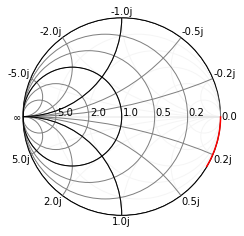

In [26]:
modelo.plot_s_smith(m=1,n=1,color='r',draw_labels=True,show_legend = False, chart_type='yz')

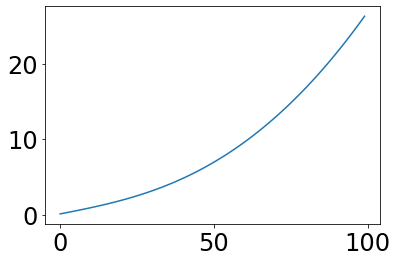

In [29]:
plt.plot(modelo.stability)

In [72]:
def Linvill(yt):
    y11 = yt[0,0]
    y12 = yt[0,1]
    y21 = yt[1,0]
    y22 = yt[1,1]
    
    print('Y11 = {:1.2e}'.format(y11))
    print('Y12 = {:1.2e}'.format(y12))
    print('Y21 = {:1.2e}'.format(y21))
    print('Y22 = {:1.2e}'.format(y22))
          
          
    C = (abs(y12*y21))/(2*y11.real*y22.real-(y12*y21).real)
    print('###############  LINVILL   #####################')
    print( 'coeficiente de linvill C= {:4.2F}' .format(C))
    if C < 1:
        print( 'Es incondicionalmente estable')
    else :
        print( 'Es potencialmente inestable')
    return C

def Stern(yg, yl, yt):
    y11 = yt[0,0]
    y12 = yt[0,1]
    y21 = yt[1,0]
    y22 = yt[1,1]
    K = (2*(y11.real+yg.real)*(y22.real+yl.real)) / (abs(y12*y21)+(y12*y21).real)
    print('###############  STERN   #####################')
    print( 'coeficiente de stern K= {:4.2F}' .format(K))
    if K > 1:
        print( 'Estable')
    else :
        print( 'Inestable')
      
    yin  = y11 - (y21*y12)/(y22+yl)
    yout = y22 - (y21*y12)/(y11+yg)
    print( 'yin  = {0.real:4.3F} {0.imag:4.2E}' .format(yin) )
    print( 'rin  = {0.real:4.3F} ' .format(1/yin.real) )
    
    print( 'yout = {0.real:4.3F} {0.imag:4.2E}' .format(yout) )
    print( 'rout = {0.real:4.3F} ' .format(1/yout.real) )
    
    
    Gg = yin.real/(yg+yin).real
    G  = abs(y21)**2 *yl.real /(yin).real  /(y22+yl).real**2
    Gt = 4* abs(y21)**2 *yl.real *yg.real /abs((y11+yg)*(y22+yl)-y21*y12)**2
    
    print( 'Gg= {0.real:4.2F} ' .format((Gg)))
    print( 'G = {0.real:4.2F} ' .format((G )))
    print( 'Gt= {0.real:4.2F} ' .format((Gt)))

    
    
Linvill(modelo[12].y[0])

Y11 = 3.23e-04+2.65e-03j
Y12 = -4.98e-07-1.11e-06j
Y21 = 3.72e-03-2.33e-03j
Y22 = 2.14e-06+7.07e-04j
###############  LINVILL   #####################
coeficiente de linvill C= 0.92
Es incondicionalmente estable


0.9174069593060677